# Imminent ICU Admission and Prolonged Stay Prediction using Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import re
import pandas as pd
import pickle
from pathlib import Path
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from utils.splits import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir/lr'),
 'dataset_csv': PosixPath('../data/proc_dataset.csv'),
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime',
  'chartinterval'],
 'imminent_adm_cols': ['hadm_id', 'processed_note', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'processed_note', 'prolonged_stay_label'],
 'dates': ['charttime', 'intime'],
 'modeldir': PosixPath('../data/workdir/lr/models'),
 'min_freq': 3,
 'ia_thresh': 0.45,
 'ps_thresh': 0.39,
 'start_seed': 127}

## LR Model Dev

In [3]:
seed = 643
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ps_df = ori_df.loc[(ori_df['chartinterval'] != 0)][args.prolonged_stay_cols].reset_index(drop=True)

print(ia_df.shape)
print(ps_df.shape)

(50809, 3)
(60830, 3)


### Imminent ICU Admission

In [4]:
df = set_group_splits(ia_df.copy(), group_col='hadm_id', seed=seed)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(1,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50809, 4), (42683, 56262), (8126, 56262), (42683,), (8126,))

In [5]:
params = {
  'class_weight': 'balanced',
  'solver': 'liblinear',
  'multi_class': 'ovr',
  'dual': True,
  'C': 0.336
}

In [6]:
clf = LogisticRegression(**params)

clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

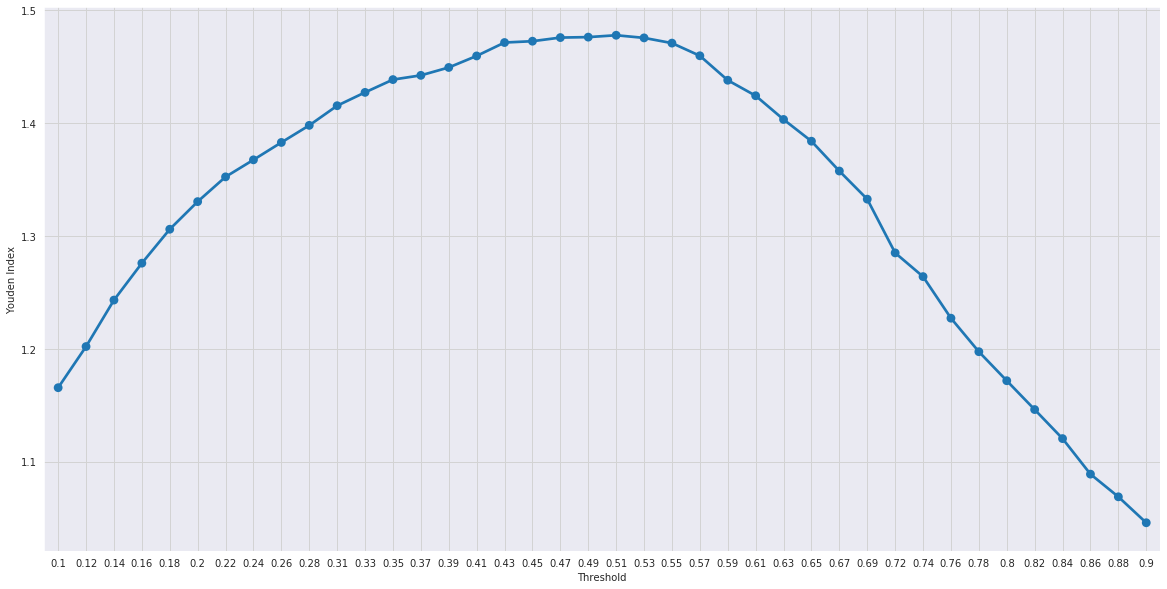

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

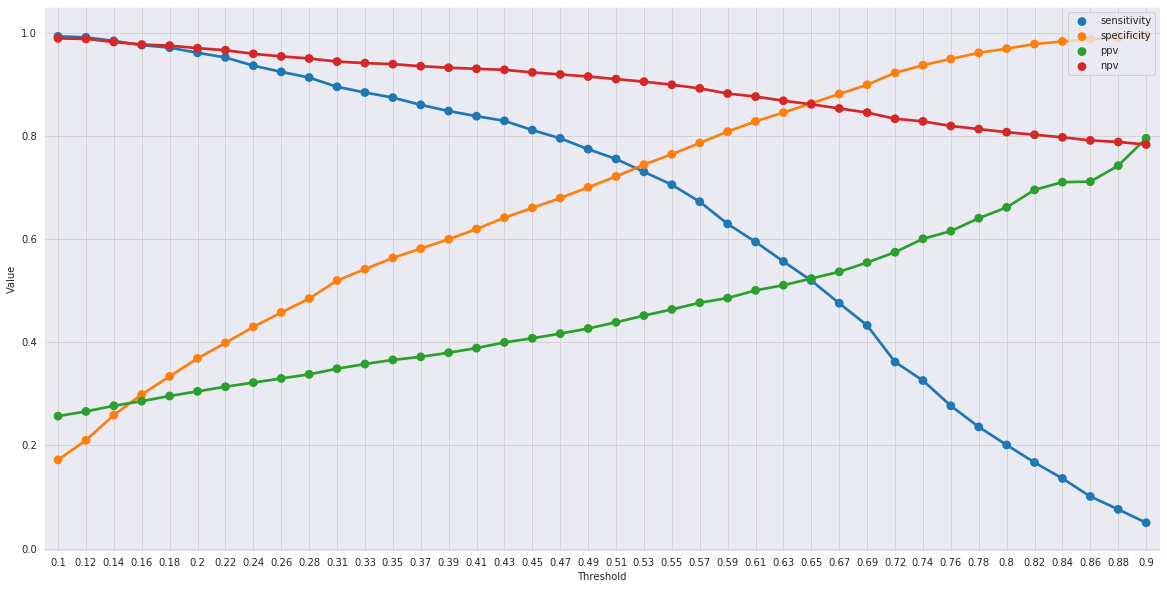

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, prob, 0.1, 0.9, 40)

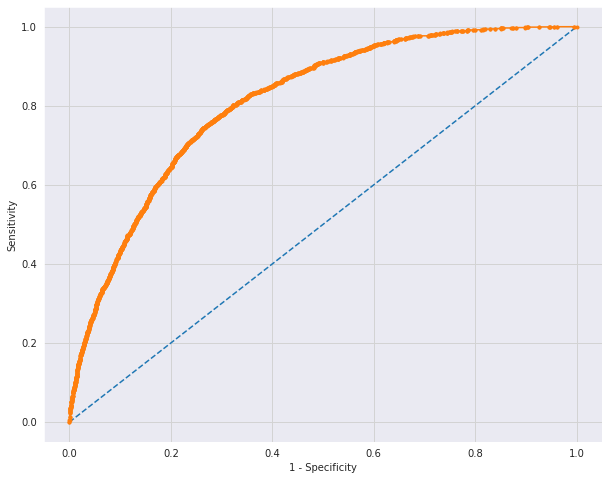

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(ax, y_test, prob)

In [10]:
thresh = 0.45
y_pred = (prob > thresh).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.812
specificity,0.661
ppv,0.408
npv,0.924
f1,0.543
auroc,0.811


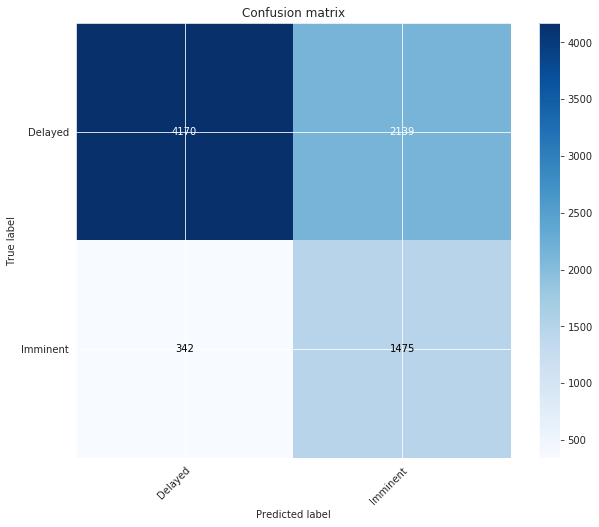

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

Text(0.5, 1.0, 'Imminent ICU Admission')

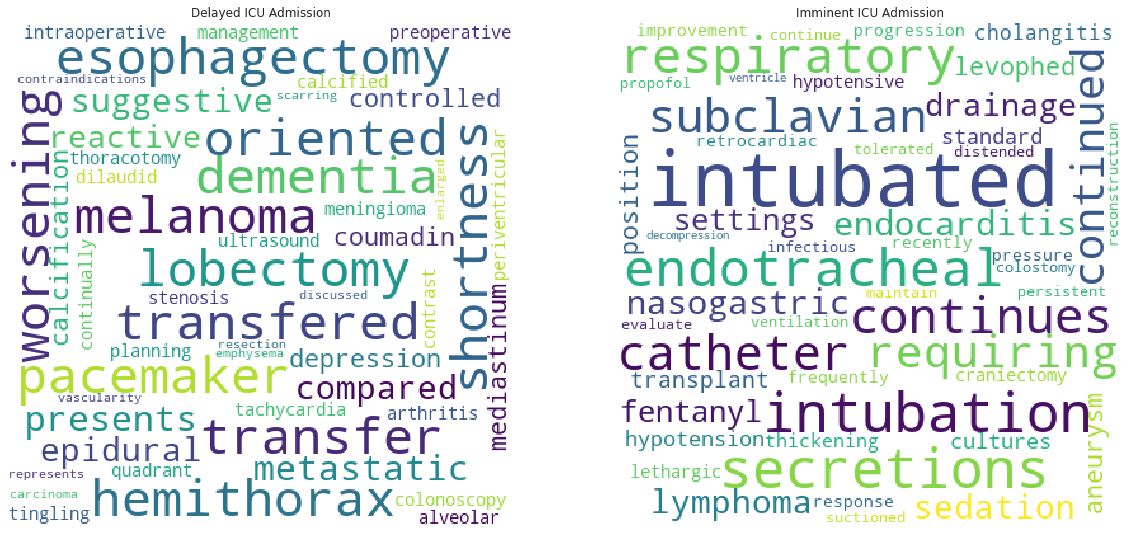

In [24]:
scores = clf.coef_[0]/clf.coef_[0].sum()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Delayed ICU Admission')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Imminent ICU Admission')

In [7]:
feature_names = vectorizer.get_feature_names()

In [8]:
rows, cols = x_test.nonzero()

In [17]:
i = 0
for row, col in zip(rows, cols):
  i += 1
  word = feature_names[col]
  if len(word.split()) > 1:
    print((feature_names[col]), x_test[row, col])
    if i > 10:
      break    

In [13]:
feature_names = vectorizer.get_feature_names()
p = re.compile('^[a-z\s]+$')
sorted_idxs = np.argsort(clf.coef_[0])
sorted_words = []
coef = []

for i in sorted_idxs:
  word = feature_names[i]
  if len(word) > 7 and word not in STOP_WORDS and p.match(word):
    sorted_words.append(word)
    coef.append(clf.coef_[0][i])

coef = np.asarray(coef)
coef = coef/coef.sum()

In [17]:
df = pd.DataFrame({'words': sorted_words, 'score': coef}, columns=['words', 'score'])

In [42]:
pos = df.head(50)
neg = df.tail(50).sort_values(by='score').reset_index(drop=True)

In [46]:
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)
crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
40,23.9,9.082,9.799,22.944,19.359,858.97,116.29,SC
34,23.9,5.497,10.038,23.661,20.554,688.75,109.72,ND
48,23.8,8.092,6.664,23.086,20.706,992.61,152.56,WV
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
17,21.4,4.066,4.922,16.692,16.264,872.51,137.13,KY


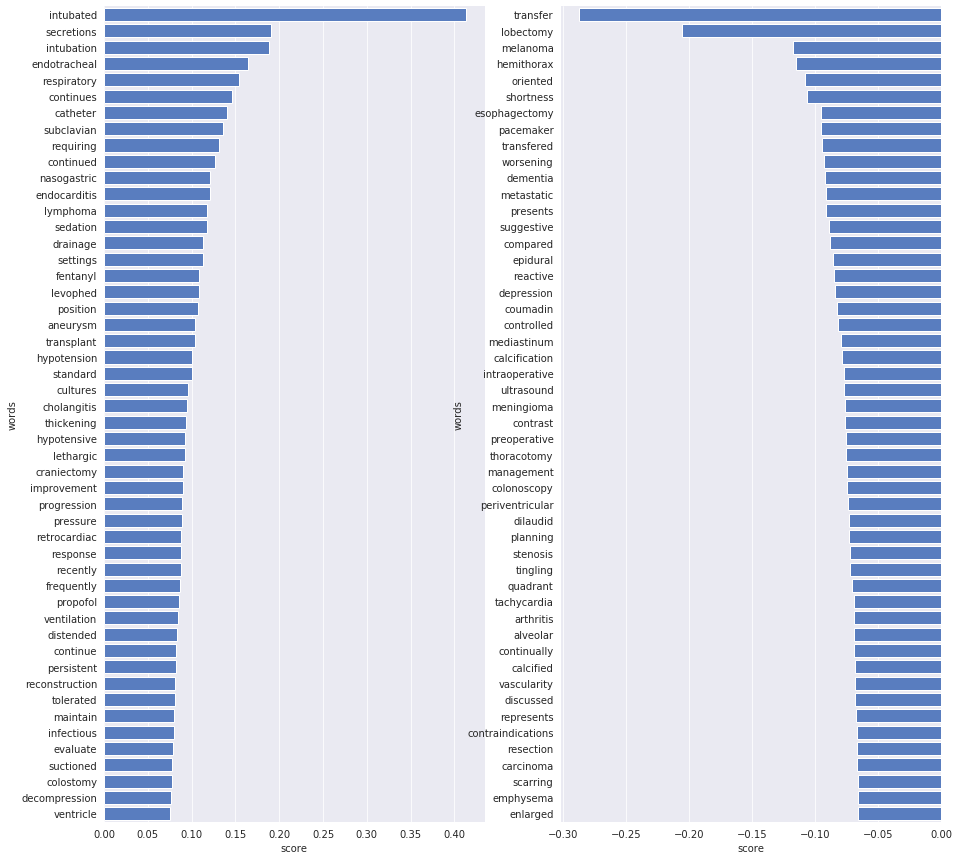

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
sns.barplot(x='score', y='words', data=pos, color='b', ax=ax[0])
sns.barplot(x='score', y='words', data=neg, color='b', ax=ax[1])


In [38]:
sorted_words[:10]

['intubated',
 'secretions',
 'intubation',
 'endotracheal',
 'respiratory',
 'continues',
 'catheter',
 'subclavian',
 'requiring',
 'continued']

In [25]:
sorted_words[:20]

[('intubated', 3.7865617893048014),
 ('secretions', 1.7429510566844209),
 ('intubation', 1.727195513842939),
 ('endotracheal', 1.509128151783027),
 ('respiratory', 1.4087136403188076),
 ('continues', 1.337884155008843),
 ('catheter', 1.2820321412155613),
 ('subclavian', 1.240293434864983),
 ('requiring', 1.2017247849137924),
 ('continued', 1.1614578709246877),
 ('nasogastric', 1.1104623044489124),
 ('endocarditis', 1.1053171861256517),
 ('lymphoma', 1.0749721670025658),
 ('sedation', 1.0744250183453599),
 ('drainage', 1.036077002887667),
 ('settings', 1.0339432655615979),
 ('fentanyl', 0.9937232711151088),
 ('levophed', 0.9932221416521247),
 ('position', 0.9804406649418086),
 ('aneurysm', 0.9525539278002301)]

### Prolonged ICU Stay

In [13]:
df = set_group_splits(ps_df.copy(), group_col='hadm_id', seed=seed)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['prolonged_stay_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['prolonged_stay_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60830, 4), (51844, 62397), (8986, 62397), (51844,), (8986,))

In [14]:
params = {
  'class_weight': 'balanced',
  'solver': 'liblinear',
  'multi_class': 'ovr',
  'dual': True,
}

In [15]:
clf = LogisticRegression(**params)

clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

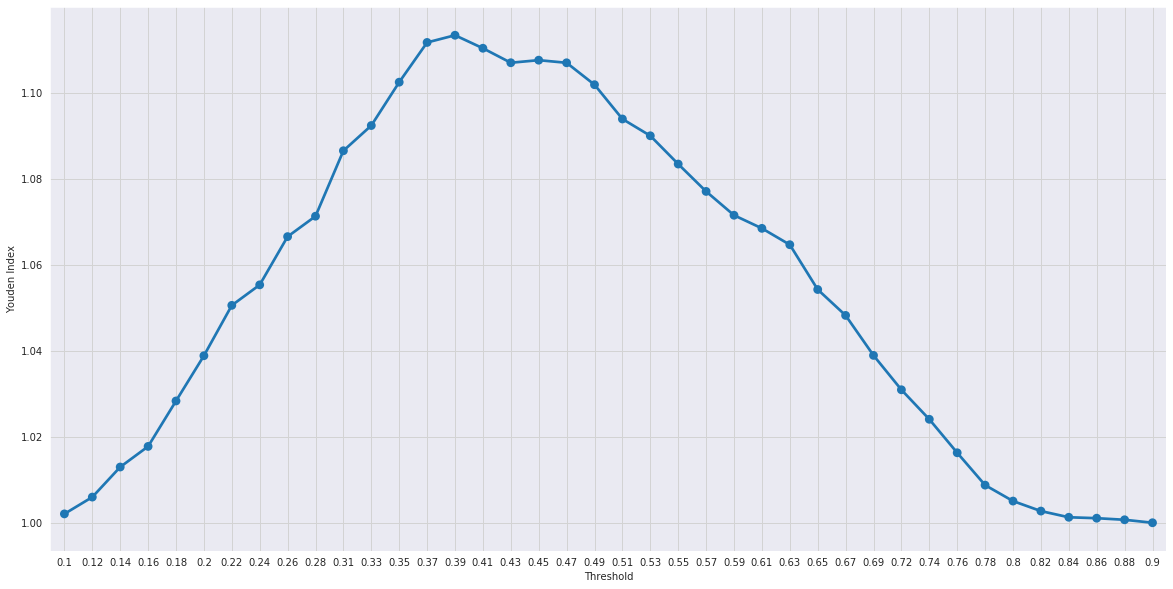

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

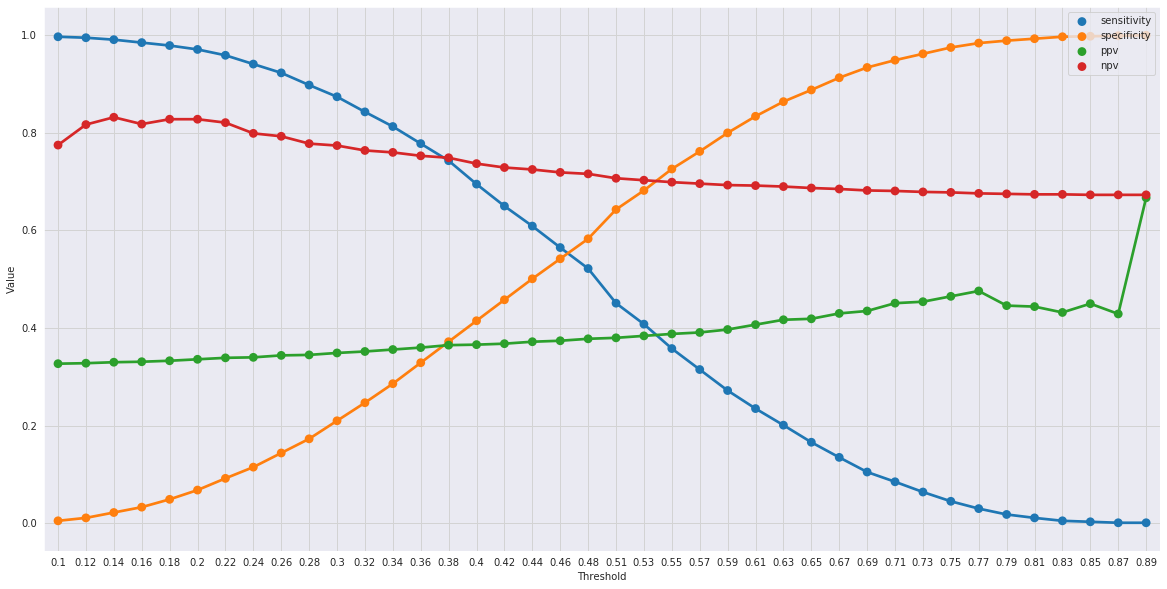

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, prob, 0.1, 0.89, 40)

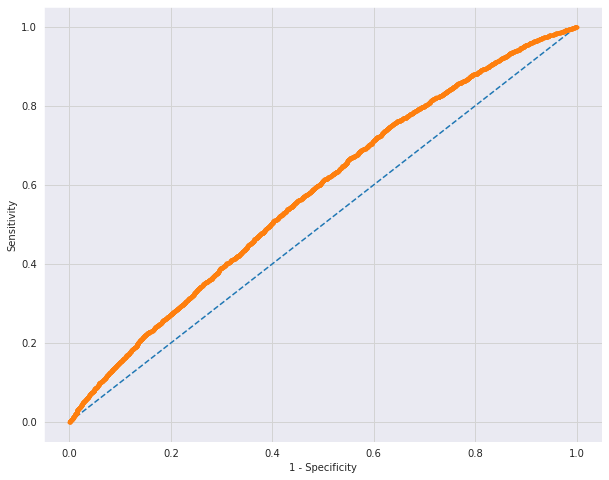

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(ax, y_test, prob)

In [19]:
thresh = 0.39
y_pred = (prob > thresh).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.718
specificity,0.395
ppv,0.366
npv,0.743
f1,0.485
auroc,0.578
prevalence,0.327


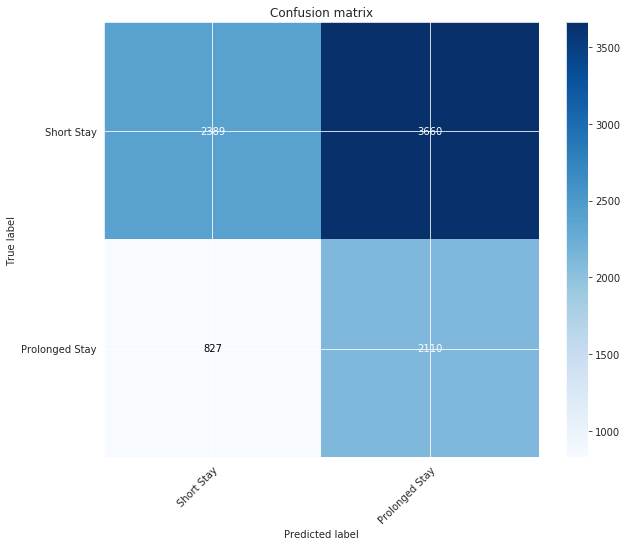

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Short Stay', 'Prolonged Stay'], normalize=False, title='Confusion matrix')

Text(0.5, 1.0, 'Prolonged Stay')

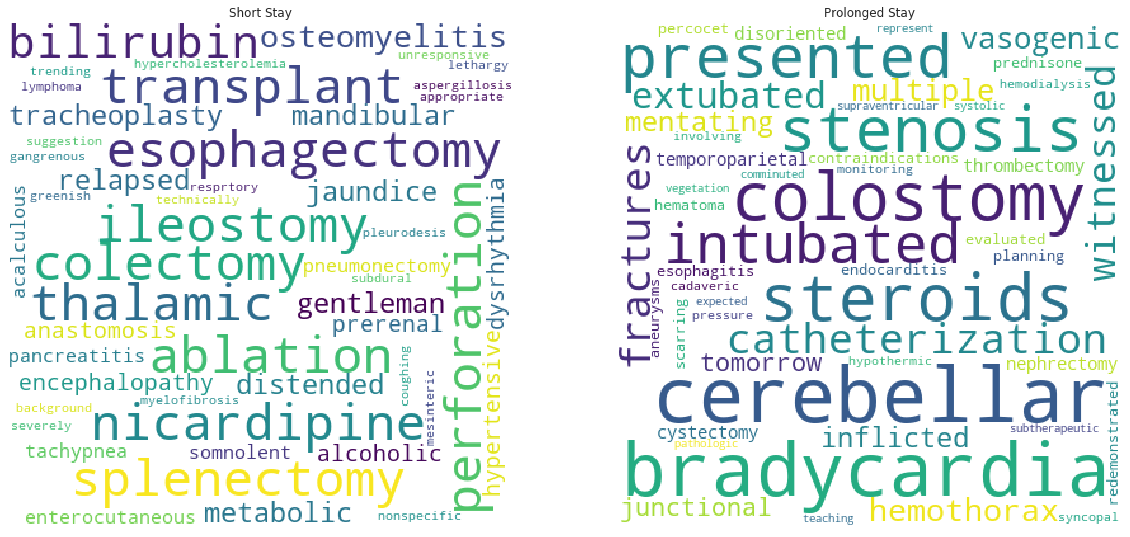

In [21]:
scores = clf.coef_[0]/clf.coef_[0].sum()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Short Stay')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Prolonged Stay')

## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

### Imminent ICU Admission

In [22]:
with open(args.workdir/f'imminent_adm_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'imminent_adm_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [23]:
bam.get_avg_metrics(conf=0.95)

,Lower,Mean,Upper
sensitivity,83.6,84.1,84.5
specificity,57.0,57.6,58.2
ppv,38.1,38.5,38.8
auroc,78.7,79.1,79.4
npv,91.6,91.9,92.2
f1,52.4,52.7,53.1


In [24]:
get_best_model(bam, fnames)

,Value,Model File
sensitivity,0.896998,imminent_adm_seed_164.pkl
specificity,0.645943,imminent_adm_seed_205.pkl
ppv,0.421979,imminent_adm_seed_143.pkl
auroc,0.823845,imminent_adm_seed_141.pkl
npv,0.951777,imminent_adm_seed_164.pkl
f1,0.563512,imminent_adm_seed_199.pkl


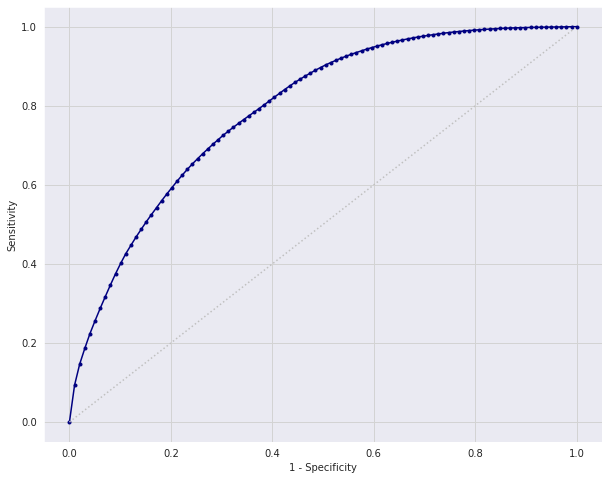

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs, is_individual=False)

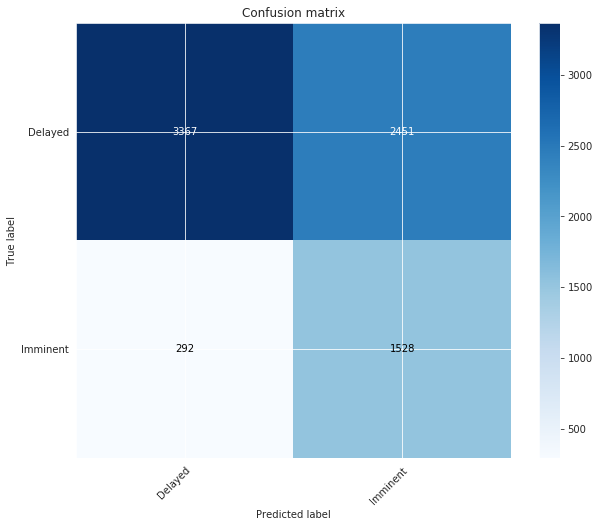

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, bam.cm_avg, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

### Prolonged ICU Stay

In [27]:
with open(args.workdir/f'prolonged_stay_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'prolonged_stay_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [28]:
bam.get_avg_metrics(conf=0.95)

,Lower,Mean,Upper
sensitivity,82.1,82.7,83.2
specificity,23.8,24.2,24.6
ppv,39.3,39.9,40.5
auroc,54.9,55.5,56.0
npv,68.4,69.6,70.7
f1,53.1,53.7,54.3


In [29]:
get_best_model(bam, fnames)

,Value,Model File
sensitivity,0.884073,prolonged_stay_seed_161.pkl
specificity,0.290935,prolonged_stay_seed_136.pkl
ppv,0.461001,prolonged_stay_seed_179.pkl
auroc,0.617243,prolonged_stay_seed_161.pkl
npv,0.796340,prolonged_stay_seed_161.pkl
f1,0.592500,prolonged_stay_seed_130.pkl


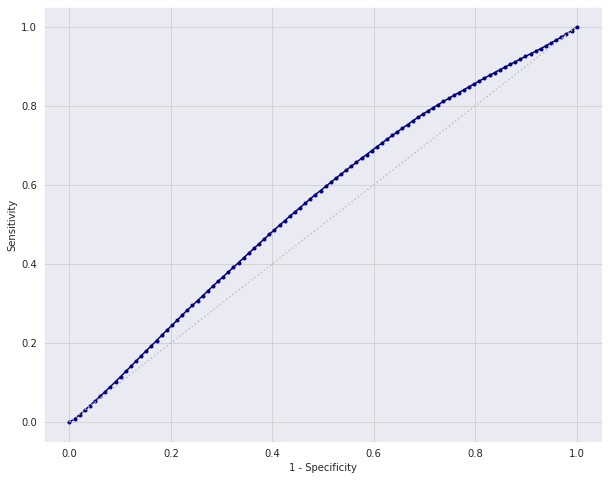

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

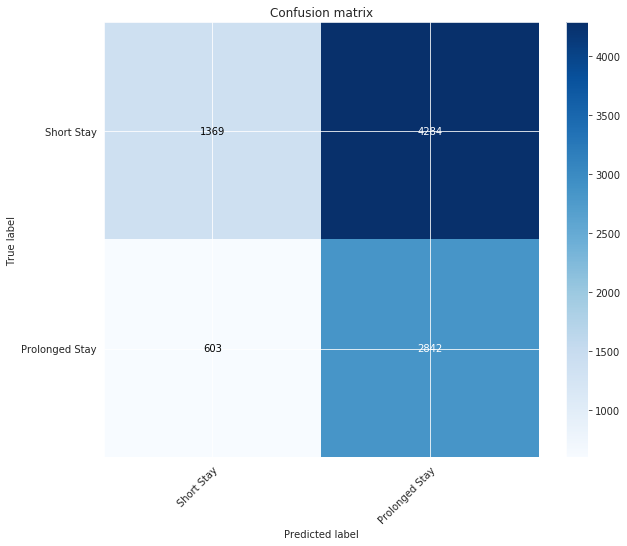

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, bam.cm_avg, classes=['Short Stay', 'Prolonged Stay'], normalize=False, title='Confusion matrix')

## Full Data

In [32]:
seed = 643
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ori_df['relative_charttime'] = (ori_df['charttime'] - ori_df['intime'])

ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols + ['relative_charttime']].reset_index(drop=True)

ps_df = ori_df.loc[(ori_df['chartinterval'] != 0)][args.prolonged_stay_cols + ['relative_charttime']].reset_index(drop=True)

In [33]:
interval_hours = 12
starting_day = -20
ending_day = -1

### Predict Imminent ICU Admission

In [34]:
df = set_group_splits(ia_df.copy(), pct=0.25, group_col='hadm_id', seed=seed)
df['prob'] = -1

vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50809, 6), (38192, 53056), (12617, 53056), (38192,), (12617,))

In [35]:
from args import ia_params
clf = LogisticRegression(**ia_params)

clf.fit(x_train, y_train)
df.loc[(df['split'] == 'test'), 'prob'] = clf.predict_proba(x_test)[:, 1]

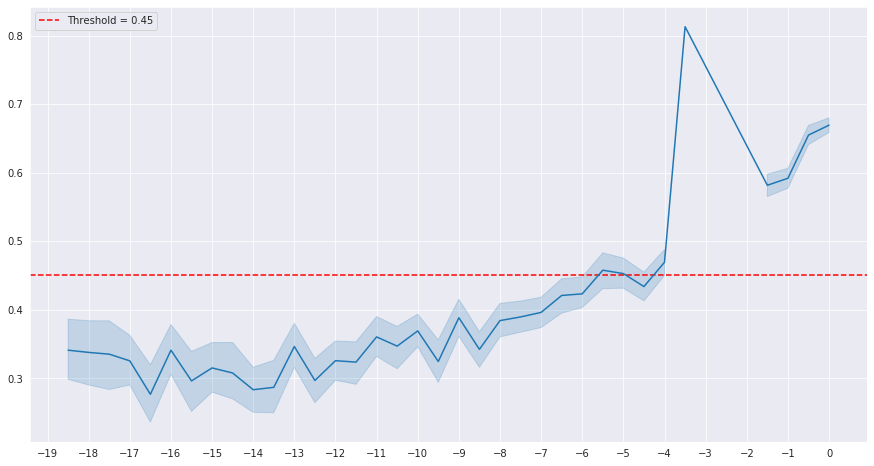

In [36]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df.loc[(df['split'] == 'test')], args.ia_thresh, starting_day, ending_day, interval_hours)

In [37]:
scores = clf.coef_[0]/clf.coef_[0].sum()

Text(0.5, 1.0, 'Positive Class')

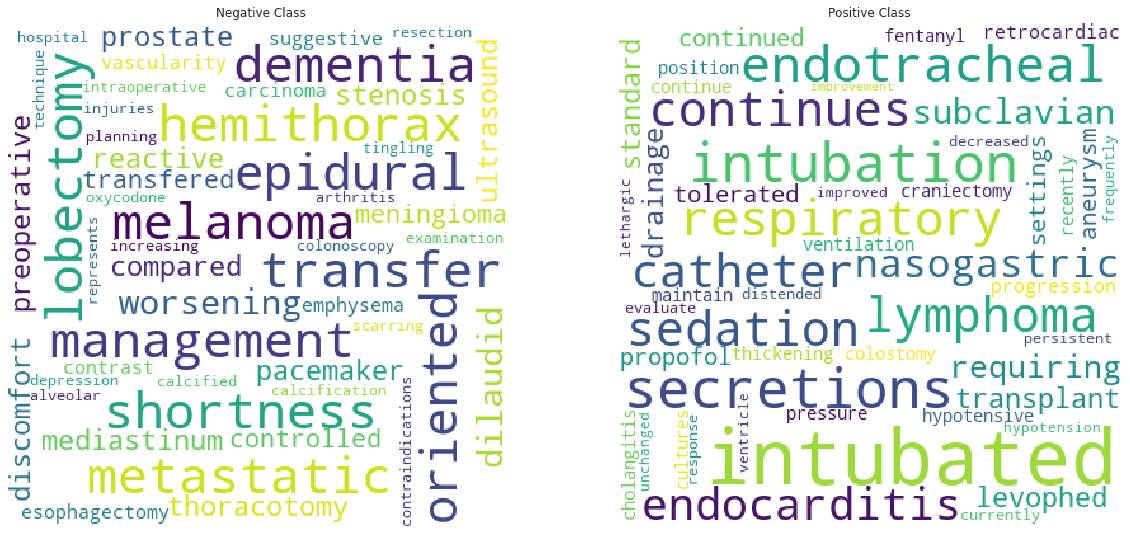

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

### Predict Prolonged ICU Stay

In [39]:
df = set_group_splits(ps_df.copy(), pct=0.25, group_col='hadm_id', seed=seed)
df['prob'] = -1

vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['prolonged_stay_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['prolonged_stay_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60830, 6), (45564, 57877), (15266, 57877), (45564,), (15266,))

In [40]:
from args import ps_params
clf = LogisticRegression(**ps_params)

clf.fit(x_train, y_train)
df.loc[(df['split'] == 'test'), 'prob'] = clf.predict_proba(x_test)[:, 1]

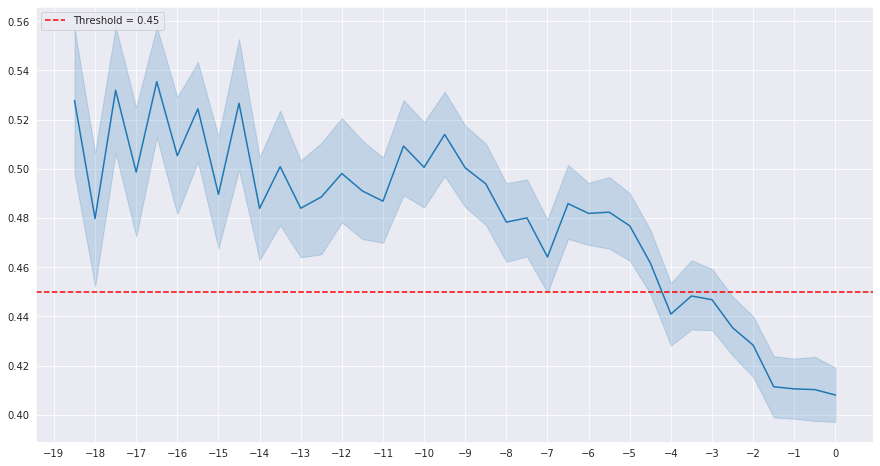

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df.loc[(df['split'] == 'test')], args.ia_thresh, starting_day, ending_day, interval_hours)

In [42]:
scores = clf.coef_[0]/clf.coef_[0].sum()

Text(0.5, 1.0, 'Positive Class')

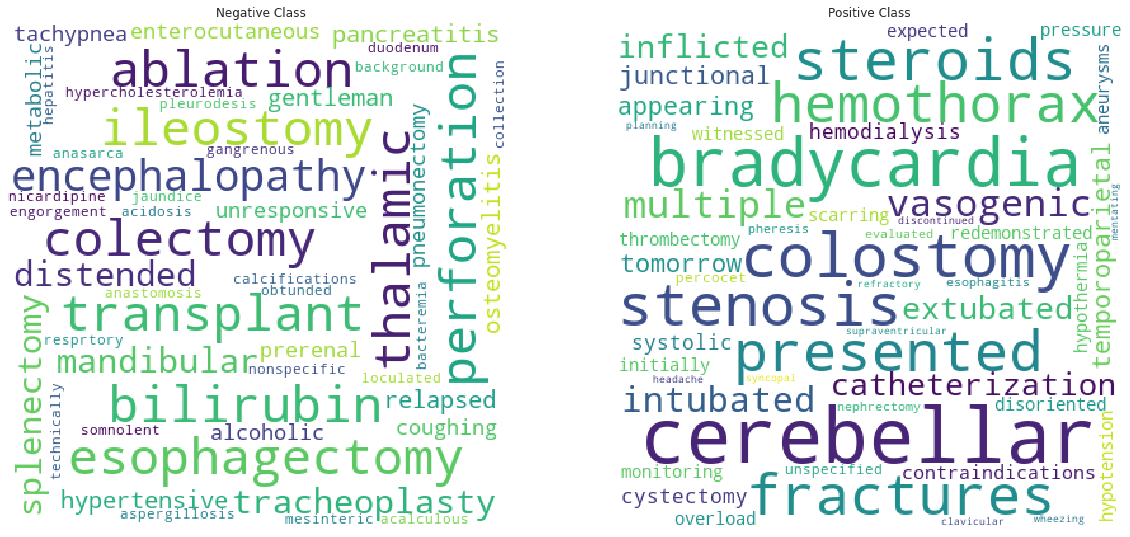

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')